<a href="https://colab.research.google.com/github/senanayake/colab-notebooks/blob/main/Graph_Based_Upgrade_Paths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Problem Overview: Org-Wide Java Dependency Upgrade Planner

Large organizations often maintain **hundreds of Java applications** across many Bitbucket repositories. Each application declares its dependencies in one or more `pom.xml` files, and over time:

- Different teams upgrade at different speeds.
- Multiple incompatible versions of the same library coexist.
- Security vulnerabilities and breaking changes accumulate.

We want to build a **dependency intelligence and upgrade planning system** that:

1. **Discovers** all Java dependencies across the org by parsing POM files.
2. Constructs two key graph structures:
   - A **Version DAG** for each library (captures upgrade paths between versions).
   - A **Bipartite Projection Graph** connecting **applications ↔ specific library versions**.
3. **Analyzes** fragmentation, risk, and upgrade opportunities.
4. **Recommends coordinated “upgrade waves”** so multiple teams can move together.
5. **Feeds execution tools** (OpenRewrite recipes, IDE plugins, Copilot/bmad helpers) to automate migrations.

This notebook section defines the **data model** and **example behavior** using a small toy dataset of 4 applications and several Java libraries. Later sections will implement code that builds and analyzes these graphs.

---

# 2. Core Concepts

## 2.1 Version DAG (per library)

For each library (identified by `groupId:artifactId`), we define a **Version DAG**:

- **Nodes** = specific versions  
  Example: `spring-boot:2.3.4`, `spring-boot:2.5.0`, `spring-boot:2.7.18`.
- **Directed edges** = allowed upgrade steps  
  Example: `2.3.4 → 2.5.0`, `2.5.0 → 2.7.18`.
- **Optional weights** = migration difficulty.

Interpretation:

> The Version DAG models “how you can move through the version space” for a given library.

We will define DAGs for Spring Boot, Jackson, Hibernate, and Log4j in our example.

---

## 2.2 Bipartite Projection Graph (Applications ↔ Library Versions)

We also define a **bipartite graph** with two types of nodes:

- **Applications**  
  Example: `OrdersAPI`, `PaymentsService`, `InventoryService`, `ReportingJob`.

- **Library-version nodes**  
  Example: `spring-boot:2.3.4`, `jackson-databind:2.9.9`, `hibernate-core:5.4.0`.

Edges represent usage:

> `App A → Library L@Version V` means “App A depends on L version V”.

This graph helps us understand:

- Version fragmentation in the org.
- Which apps should be grouped into upgrade waves.
- Which upgrades will have the highest impact.
- Where OpenRewrite recipes will have high reuse value.

---

# 3. Example Dataset: 4 Applications

We define 4 example applications using various versions of 4 important Java libraries.

## 3.1 Current App Dependencies (simulated from POMs)

| Application        | Spring Boot        | Jackson       | Hibernate        | Logging        |
|--------------------|--------------------|---------------|------------------|----------------|
| OrdersAPI          | 2.3.4.RELEASE      | 2.9.9         | 5.3.0.Final      | log4j 1.2.17   |
| PaymentsService    | 2.3.4.RELEASE      | 2.10.1        | 5.4.0.Final      | log4j 1.2.17   |
| InventoryService   | 2.5.0              | 2.10.1        | (none)           | SLF4J only     |
| ReportingJob       | 1.5.22.RELEASE     | 2.8.11        | 5.2.0.Final      | log4j 1.2.17   |

Observations:

- Spring Boot has **three versions** in use.
- Jackson has **three versions** in use.
- Hibernate has **three versions** in use.
- Log4j v1 is used by **three apps** and is considered insecure.

These represent realistic fragmentation issues in large enterprise Java estates.

---

## 3.2 Target “Org Standard” Versions

Assume platform architects have defined these target versions:

- Spring Boot → **2.7.18**  
- Jackson → **2.13.5**  
- Hibernate → **5.6.15.Final**  
- Log4j → **2.17.2**  

The upgrade planner will attempt to standardize apps onto these versions.

---

# 4. Version DAGs for Each Library

Below are the simplified version DAGs for each library.

## 4.1 Spring Boot Version DAG

Nodes:
- `1.5.22.RELEASE`
- `2.3.4.RELEASE`
- `2.5.0`
- `2.7.18` (target)
- `3.2.0` (future)

Edges:
- `1.5.22 → 2.3.4`
- `2.3.4 → 2.5.0`
- `2.5.0 → 2.7.18`
- `2.7.18 → 3.2.0`

Visual:
1.5.22 ─▶ 2.3.4 ─▶ 2.5.0 ─▶ 2.7.18 ─▶ 3.2.0

---

## 4.2 Jackson Version DAG

Nodes:
- `2.8.11`
- `2.9.9`
- `2.10.1`
- `2.13.5` (target)

Edges:
- `2.8.11 → 2.9.9`
- `2.9.9 → 2.10.1`
- `2.10.1 → 2.13.5`

---

## 4.3 Hibernate Version DAG

Nodes:
- `5.2.0.Final`
- `5.3.0.Final`
- `5.4.0.Final`
- `5.6.15.Final` (target)

Edges:
- `5.2.0 → 5.3.0`
- `5.3.0 → 5.4.0`
- `5.4.0 → 5.6.15`

---

## 4.4 Log4j Upgrade DAG (v1 to v2)

Nodes:
- `log4j:1.2.17`
- `log4j-core:2.17.2` (target)

Edge:
- `log4j:1.2.17 → log4j-core:2.17.2`

This represents a **cross-artifact migration** suited to OpenRewrite automation.

---

# 5. Bipartite Projection Graph (Applications ↔ Library Versions)

We now connect each application to the specific versions it uses.

Example edges:

OrdersAPI → spring-boot:2.3.4
OrdersAPI → jackson-databind:2.9.9
OrdersAPI → hibernate-core:5.3.0
OrdersAPI → log4j:1.2.17

PaymentsService → spring-boot:2.3.4
PaymentsService → jackson-databind:2.10.1
PaymentsService → hibernate-core:5.4.0
PaymentsService → log4j:1.2.17

InventoryService → spring-boot:2.5.0
InventoryService → jackson-databind:2.10.1


ReportingJob → spring-boot:1.5.22
ReportingJob → jackson-databind:2.8.11
ReportingJob → hibernate-core:5.2.0
ReportingJob → log4j:1.2.17


This structure enables:

- Counting how many apps use each version.
- Detecting fragmentation.
- Grouping apps into **upgrade waves**.
- Identifying where OpenRewrite automation yields the most value.

---

# 6. Expected System Behavior on This Example

## 6.1 Detect Fragmentation & Risks

The system should detect:

- **Log4j v1** is used by 3 apps → urgent security upgrade wave.
- **Spring Boot** has 3 versions → consolidation needed.
- **Jackson** and **Hibernate** are also fragmented.

---

## 6.2 Recommend Upgrade Waves

### Wave 0: Security
- Migrate all apps using `log4j:1.2.17` → `log4j2:2.17.2`.
- Affects: `OrdersAPI`, `PaymentsService`, `ReportingJob`.

### Wave 1: Spring Boot Consolidation
Target: `2.7.18`.

Example upgrade paths:
- `ReportingJob: 1.5.22 → 2.3.4 → 2.5.0 → 2.7.18`
- `OrdersAPI: 2.3.4 → 2.5.0 → 2.7.18`
- `PaymentsService: 2.3.4 → 2.5.0 → 2.7.18`
- `InventoryService: 2.5.0 → 2.7.18`

### Wave 2: Jackson & Hibernate Alignment
Target Jackson: `2.13.5`  
Target Hibernate: `5.6.15.Final`

Apps will be grouped based on shared starting versions.

---

## 6.3 Identify Where OpenRewrite Recipes Are Worth Building

For each candidate upgrade, the system should:

- Count how many apps share the same source version.
- Estimate potential efficiency gain from a shared OpenRewrite recipe.
- Recommend recipe generation only when enough apps will benefit.

Examples:
- A single recipe for `spring-boot:2.3.4 → 2.7.18` is highly valuable (used by 2 apps).
- A recipe for `spring-boot:1.5.22 → 2.7.18` may be less valuable (used by only 1 app).

---

# 7. Next Steps in This Notebook

Next, we will:

1. Define the example data structures for DAGs and dependencies.
2. Build the Version DAGs in Python.
3. Build the bipartite Apps ↔ LibraryVersions graph.
4. Compute:
   - App counts per version
   - Fragmentation metrics
   - Simple upgrade wave suggestions
5. Prepare for later:
   - Shortest-path upgrade calculations
   - Wave clustering
   - OpenRewrite ROI heuristics




# Dependency Graph Demo: Version DAGs, Apps ↔ LibraryVersions, and Upgrade Waves

This Colab section builds a **self-contained demo** of the ideas we discussed:

- Define example data for:
  - **Version DAGs** per library
  - **Application dependencies** (App ↔ LibraryVersion)
- Build:
  - Version DAGs in Python
  - A **bipartite graph**: Apps ↔ LibraryVersions
- Compute:
  - App counts per version
  - Fragmentation metrics per library
  - Simple upgrade wave suggestions
- Optionally visualize some graphs

You can run the cells top-to-bottom.

---

## 1. Setup: Imports and Example Data


In [2]:
!pip install networkx matplotlib --quiet

import networkx as nx
import math
import matplotlib.pyplot as plt
from collections import defaultdict, Counter


### 1.1 Example Libraries and Versions

We will use the same example from the spec:

Libraries:
- Spring Boot (`spring-boot`)
- Jackson (`jackson-databind`)
- Hibernate (`hibernate-core`)
- Log4j v1 (`log4j`) and Log4j2 (`log4j2` for conceptual migration)

We define:
- Version DAGs per library
- Applications and the versions they currently use


In [1]:
# Version DAG definitions per library
# Each DAG is: {version: [list of directly upgradable versions]}
version_dags = {
    "spring-boot": {
        "1.5.22.RELEASE": ["2.3.4.RELEASE"],
        "2.3.4.RELEASE": ["2.5.0"],
        "2.5.0": ["2.7.18"],
        "2.7.18": ["3.2.0"],
        "3.2.0": [],
    },
    "jackson-databind": {
        "2.8.11": ["2.9.9"],
        "2.9.9": ["2.10.1"],
        "2.10.1": ["2.13.5"],
        "2.13.5": [],
    },
    "hibernate-core": {
        "5.2.0.Final": ["5.3.0.Final"],
        "5.3.0.Final": ["5.4.0.Final"],
        "5.4.0.Final": ["5.6.15.Final"],
        "5.6.15.Final": [],
    },
    # Treat log4j v1 → log4j2 v2 as a conceptual cross-artifact DAG
    "log4j": {
        "1.2.17": [],  # we'll model migration via a mapping to log4j2
    },
    "log4j2": {
        "2.17.2": [],
    }
}

# Org standard target versions per library
target_versions = {
    "spring-boot": "2.7.18",
    "jackson-databind": "2.13.5",
    "hibernate-core": "5.6.15.Final",
    "log4j2": "2.17.2",  # conceptual target when migrating away from log4j v1
}

# Application dependencies: App -> {library: version}
app_deps = {
    "OrdersAPI": {
        "spring-boot": "2.3.4.RELEASE",
        "jackson-databind": "2.9.9",
        "hibernate-core": "5.3.0.Final",
        "log4j": "1.2.17",
    },
    "PaymentsService": {
        "spring-boot": "2.3.4.RELEASE",
        "jackson-databind": "2.10.1",
        "hibernate-core": "5.4.0.Final",
        "log4j": "1.2.17",
    },
    "InventoryService": {
        "spring-boot": "2.5.0",
        "jackson-databind": "2.10.1",
        # hibernate-core: none
        # logging: uses SLF4J only
    },
    "ReportingJob": {
        "spring-boot": "1.5.22.RELEASE",
        "jackson-databind": "2.8.11",
        "hibernate-core": "5.2.0.Final",
        "log4j": "1.2.17",
    },
}


2. Build Version DAGs in Python

We’ll build one NetworkX DiGraph per library.

In [3]:
def build_version_dag(library_name, dag_dict):
    """
    Build a NetworkX DiGraph for a single library's version DAG.
    """
    G = nx.DiGraph()
    for version, successors in dag_dict.items():
        G.add_node(version)
        for succ in successors:
            G.add_edge(version, succ)
    return G

version_graphs = {
    lib: build_version_dag(lib, dag)
    for lib, dag in version_dags.items()
}

version_graphs.keys()


dict_keys(['spring-boot', 'jackson-databind', 'hibernate-core', 'log4j', 'log4j2'])

### 2.1 Visualize a Version DAG (Spring Boot)

This is optional but nice for intuition.

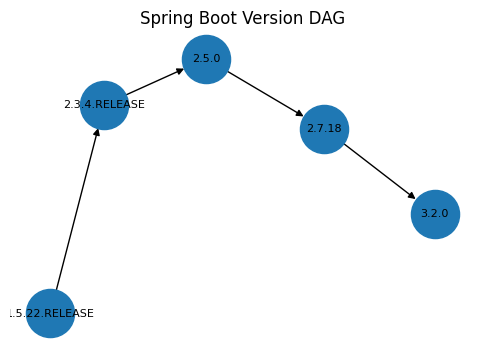

In [4]:
spring_boot_graph = version_graphs["spring-boot"]

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(spring_boot_graph, seed=42)
nx.draw_networkx(spring_boot_graph, pos, with_labels=True, node_size=1200, font_size=8)
plt.title("Spring Boot Version DAG")
plt.axis("off")
plt.show()


3. Build the Bipartite Apps ↔ LibraryVersions Graph

We’ll build a single graph where nodes are:

Apps: ("app", app_name)

LibraryVersions: ("libver", library, version)

Edges: app → lib-version.

In [5]:
B = nx.Graph()  # bipartite undirected for simplicity

# Add nodes and edges
for app, deps in app_deps.items():
    app_node = ("app", app)
    B.add_node(app_node, bipartite="app")
    for lib, ver in deps.items():
        libver_node = ("libver", lib, ver)
        B.add_node(libver_node, bipartite="libver")
        B.add_edge(app_node, libver_node)

len(B.nodes()), len(B.edges())


(14, 14)

### 3.1 Inspect the bipartite graph


In [6]:
# List library-version nodes and their connected apps
libver_to_apps = defaultdict(list)
for node in B.nodes:
    if node[0] == "libver":
        for neighbor in B.neighbors(node):
            if neighbor[0] == "app":
                libver_to_apps[node].append(neighbor[1])

for libver, apps in libver_to_apps.items():
    _, lib, ver = libver
    print(f"{lib}:{ver} is used by apps: {apps}")


spring-boot:2.3.4.RELEASE is used by apps: ['OrdersAPI', 'PaymentsService']
jackson-databind:2.9.9 is used by apps: ['OrdersAPI']
hibernate-core:5.3.0.Final is used by apps: ['OrdersAPI']
log4j:1.2.17 is used by apps: ['OrdersAPI', 'PaymentsService', 'ReportingJob']
jackson-databind:2.10.1 is used by apps: ['PaymentsService', 'InventoryService']
hibernate-core:5.4.0.Final is used by apps: ['PaymentsService']
spring-boot:2.5.0 is used by apps: ['InventoryService']
spring-boot:1.5.22.RELEASE is used by apps: ['ReportingJob']
jackson-databind:2.8.11 is used by apps: ['ReportingJob']
hibernate-core:5.2.0.Final is used by apps: ['ReportingJob']


### 3.2 Optional: Visualize a small bipartite view

We’ll draw apps on one side, library-versions on the other.


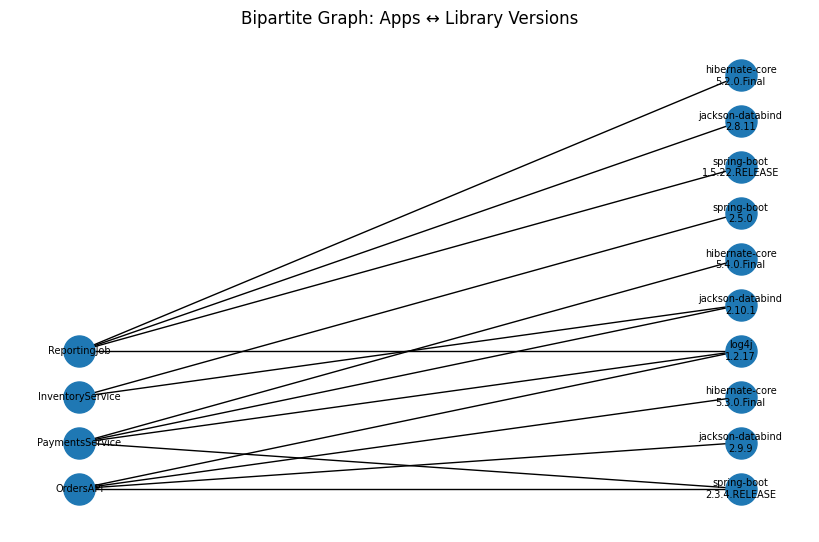

In [7]:
plt.figure(figsize=(8, 5))

# Separate nodes by type
apps = [n for n in B.nodes if n[0] == "app"]
libvers = [n for n in B.nodes if n[0] == "libver"]

pos = {}
pos.update((node, (0, i)) for i, node in enumerate(apps))      # x=0
pos.update((node, (1, i)) for i, node in enumerate(libvers))   # x=1

nx.draw(B, pos, with_labels=False, node_size=500)

# Add simple labels
for node, (x, y) in pos.items():
    if node[0] == "app":
        label = node[1]
    else:
        _, lib, ver = node
        label = f"{lib}\n{ver}"
    plt.text(x, y, label, fontsize=7, ha="center", va="center")

plt.title("Bipartite Graph: Apps ↔ Library Versions")
plt.axis("off")
plt.show()


4. Compute App Counts per Version

We want to know: for each (library, version), how many apps depend on it.

In [8]:
# Count apps per (library, version)
apps_per_version = Counter()

for app, deps in app_deps.items():
    for lib, ver in deps.items():
        apps_per_version[(lib, ver)] += 1

print("Apps per (library, version):\n")
for (lib, ver), count in sorted(apps_per_version.items()):
    print(f"{lib:15} {ver:15} -> {count} app(s)")


Apps per (library, version):

hibernate-core  5.2.0.Final     -> 1 app(s)
hibernate-core  5.3.0.Final     -> 1 app(s)
hibernate-core  5.4.0.Final     -> 1 app(s)
jackson-databind 2.10.1          -> 2 app(s)
jackson-databind 2.8.11          -> 1 app(s)
jackson-databind 2.9.9           -> 1 app(s)
log4j           1.2.17          -> 3 app(s)
spring-boot     1.5.22.RELEASE  -> 1 app(s)
spring-boot     2.3.4.RELEASE   -> 2 app(s)
spring-boot     2.5.0           -> 1 app(s)


5. Fragmentation Metrics per Library

We’ll compute:

How many distinct versions exist per library.

A simple version entropy metric per library, to quantify fragmentation.

In [9]:
# Build mapping: library -> list of versions used across all apps
library_versions_used = defaultdict(list)

for (lib, ver), count in apps_per_version.items():
    library_versions_used[lib].extend([ver] * count)

def version_entropy(versions):
    """
    Compute Shannon entropy of version distribution for a given library.
    Versions list contains repeated entries (one per app that uses it).
    """
    if not versions:
        return 0.0
    counts = Counter(versions)
    total = sum(counts.values())
    H = 0.0
    for c in counts.values():
        p = c / total
        H -= p * math.log2(p)
    return H

print("Fragmentation metrics per library:\n")
for lib, versions in library_versions_used.items():
    distinct_versions = sorted(set(versions))
    H = version_entropy(versions)
    print(f"Library: {lib}")
    print(f"  Distinct versions: {distinct_versions}")
    print(f"  Number of distinct versions: {len(distinct_versions)}")
    print(f"  Version entropy (H): {H:.3f}")
    print()


Fragmentation metrics per library:

Library: spring-boot
  Distinct versions: ['1.5.22.RELEASE', '2.3.4.RELEASE', '2.5.0']
  Number of distinct versions: 3
  Version entropy (H): 1.500

Library: jackson-databind
  Distinct versions: ['2.10.1', '2.8.11', '2.9.9']
  Number of distinct versions: 3
  Version entropy (H): 1.500

Library: hibernate-core
  Distinct versions: ['5.2.0.Final', '5.3.0.Final', '5.4.0.Final']
  Number of distinct versions: 3
  Version entropy (H): 1.585

Library: log4j
  Distinct versions: ['1.2.17']
  Number of distinct versions: 1
  Version entropy (H): 0.000



6. Simple Upgrade Wave Suggestions

We’ll use a very simple heuristic:

For each library:

Only consider libraries that have a target version defined.

For each non-target version in use:

If that version is used by ≥ 2 apps, suggest a wave:

Wave = group of apps that should upgrade from that version to the target.

Also print apps on “lonely” versions (1 app) as candidates for smaller waves.

This is not optimizing effort, just illustrating the concept.

In [10]:
def suggest_upgrade_waves(app_deps, target_versions, min_wave_size=2):
    """
    Suggest simple upgrade waves:
    - For each library with a target version
    - For each non-target version used by >= min_wave_size apps
    - Group those apps into an "upgrade wave"
    """
    # Build library -> version -> apps
    lib_ver_apps = defaultdict(lambda: defaultdict(list))
    for app, deps in app_deps.items():
        for lib, ver in deps.items():
            lib_ver_apps[lib][ver].append(app)

    waves = []

    for lib, ver_to_apps in lib_ver_apps.items():
        target = target_versions.get(lib)
        if not target:
            # no standard target defined
            continue

        for ver, apps in ver_to_apps.items():
            if ver == target:
                continue  # already on target
            if len(apps) >= min_wave_size:
                waves.append({
                    "library": lib,
                    "from_version": ver,
                    "to_version": target,
                    "apps": apps,
                })

    return waves, lib_ver_apps

waves, lib_ver_apps = suggest_upgrade_waves(app_deps, target_versions, min_wave_size=2)

print("Suggested Upgrade Waves (simple heuristic):\n")
for i, wave in enumerate(waves, start=1):
    print(f"Wave {i}: Library '{wave['library']}'")
    print(f"  From version: {wave['from_version']}")
    print(f"  To   version: {wave['to_version']}")
    print(f"  Apps: {wave['apps']}")
    print()

print("Single-app versions (possible one-off upgrades):\n")
for lib, ver_to_apps in lib_ver_apps.items():
    target = target_versions.get(lib)
    if not target:
        continue
    singles = [(ver, apps) for ver, apps in ver_to_apps.items()
               if ver != target and len(apps) == 1]
    if not singles:
        continue
    print(f"Library: {lib}")
    for ver, apps in singles:
        print(f"  Version {ver} used by {apps} (wave size = 1)")
    print()


Suggested Upgrade Waves (simple heuristic):

Wave 1: Library 'spring-boot'
  From version: 2.3.4.RELEASE
  To   version: 2.7.18
  Apps: ['OrdersAPI', 'PaymentsService']

Wave 2: Library 'jackson-databind'
  From version: 2.10.1
  To   version: 2.13.5
  Apps: ['PaymentsService', 'InventoryService']

Single-app versions (possible one-off upgrades):

Library: spring-boot
  Version 2.5.0 used by ['InventoryService'] (wave size = 1)
  Version 1.5.22.RELEASE used by ['ReportingJob'] (wave size = 1)

Library: jackson-databind
  Version 2.9.9 used by ['OrdersAPI'] (wave size = 1)
  Version 2.8.11 used by ['ReportingJob'] (wave size = 1)

Library: hibernate-core
  Version 5.3.0.Final used by ['OrdersAPI'] (wave size = 1)
  Version 5.4.0.Final used by ['PaymentsService'] (wave size = 1)
  Version 5.2.0.Final used by ['ReportingJob'] (wave size = 1)



7. (Optional) Show Upgrade Paths for a Wave

For each wave, we can compute a path along the Version DAG from from_version to target_version for that library.
We’ll use simple shortest-path search on the version DAG.

In [11]:
def find_upgrade_path(lib, start_ver, target_ver, version_graphs):
    """
    Find a shortest path from start_ver to target_ver in the library's version DAG.
    Returns a list of versions [start_ver, ..., target_ver] or None if no path.
    """
    G = version_graphs.get(lib)
    if G is None:
        return None
    if start_ver not in G or target_ver not in G:
        return None
    try:
        path = nx.shortest_path(G, source=start_ver, target=target_ver)
        return path
    except nx.NetworkXNoPath:
        return None

print("Upgrade paths for suggested waves:\n")

for i, wave in enumerate(waves, start=1):
    lib = wave["library"]
    from_ver = wave["from_version"]
    to_ver = wave["to_version"]
    path = find_upgrade_path(lib, from_ver, to_ver, version_graphs)
    print(f"Wave {i}: {lib} {from_ver} → {to_ver}")
    if path:
        print(f"  Suggested path: {' -> '.join(path)}")
    else:
        print("  No path found in DAG (check DAG definition).")
    print()


Upgrade paths for suggested waves:

Wave 1: spring-boot 2.3.4.RELEASE → 2.7.18
  Suggested path: 2.3.4.RELEASE -> 2.5.0 -> 2.7.18

Wave 2: jackson-databind 2.10.1 → 2.13.5
  Suggested path: 2.10.1 -> 2.13.5



✅ How CVEs Drive Remediation in a Dependency Upgrade Platform

CVEs (Common Vulnerabilities and Exposures) are the core signals that transform your upgrade system from “nice-to-have modernization” into mandatory risk remediation.

They provide the why behind upgrades, not just the what.

In your platform, CVEs influence remediation through four layers:

1. Annotate Version DAG Nodes With Security Metadata

Every node of the Version DAG becomes enriched with:

Known CVEs affecting that version

CVE severity (CVSS score)

Whether the version is:

Vulnerable

End-of-life

Actively maintained

Fixed-in version info (taken from NVD, GitHub Security Advisories, or vendor data)

Example annotation (Spring Boot):
spring-boot:2.3.4.RELEASE
  CVEs: CVE-2021-22118 (7.5), CVE-2021-22112 (6.8)
  Vulnerable: Yes
  Fixed in: 2.4.0+

Example annotation (Log4j 1.2.17):
log4j:1.2.17
  CVEs: multiple, severe
  Vulnerable: Yes
  EOL: Yes
  No fixed version — must migrate to Log4j2

Why this matters

The Version DAG becomes a risk map, not just a version map.

2. Compute Risk Profiles Per Application Via the Bipartite Graph

Since each app is connected to the library-version nodes it uses, you compute an application CVE exposure score:

For each app:

Get all its library-version nodes.

For each version:

Sum (or max) the CVSS scores of its CVEs.

Optionally apply weighting:

Critical CVEs weighted more

Exploited-in-the-wild CVEs weighted more

Public RCE = force immediate remediation

Example:

OrdersAPI uses:

Spring Boot 2.3.4 → CVE score = 7.5

Jackson 2.9.9 → score = 8.1

Log4j 1.2.17 → score = 10 (major RCE class issue, no vendor support)

Aggregate Risk Example:

OrdersAPI Risk = High
PaymentsService Risk = High
InventoryService Risk = Medium
ReportingJob Risk = High


Now your platform knows which apps are highest risk.

3. Detect “Risk Clusters” in the Org

Because the bipartite graph connects all apps to all vulnerable versions, you detect:

✔ Clusters where many apps share the same vulnerable version

Example:

log4j:1.2.17 → used by 3 apps
spring-boot:2.3.4 → used by 2 apps
hibernate-core:5.2.0 → used by 1 app


This immediately produces:

High-impact immediate remediation waves

Prioritization based on org-wide risk footprint

4. Drive Remediation Waves Based on Risk & Impact

This is where CVEs create real action.

Your system computes:

📌 CVE Weighted Impact Score for Each Library-Version

For each version node:

Impact
(
𝑣
)
=
(
∑
CVSS_scores
(
𝑣
)
)
×
(
number of apps using
𝑣
)
Impact(v)=(∑CVSS_scores(v))×(number of apps using v)

This gives:

Log4j 1.2.17 → huge impact score

Spring Boot 2.3.4 → moderate-high

Jackson 2.8.11 → low-medium

This ranking directly drives your upgrade wave planning.

5. Select Remediation Waves Using Optimization

You can now compute:

Max CVE-reduction per unit of engineering effort

Largest clusters to remediate first

Best shared upgrade paths so OpenRewrite can help

Example Wave Output:

Wave 0 – Security Critical

Replace log4j:1.2.17 with log4j2:2.17.2

Affects:

OrdersAPI

PaymentsService

ReportingJob

Expected CVE reduction: massive

Wave 1 – Spring Boot Vulnerability Alignment

Upgrade 1.5.22 and 2.3.4 → 2.7.18

Reduces 4 CVEs across 3 apps

Wave 2 – Jackson Data Bind

Upgrade old Jackson (2.9.9, 2.8.11) → 2.13.5

Reduces 2 serialization-related RCE risks

6. Determine Required Upgrade Paths for CVE Remediation (Shortest Path)

Because the Version DAG includes “fixed in” versions, you can compute:

Given a vulnerable version, find the shortest upgrade path to a non-vulnerable version.

Example:

spring-boot:2.3.4 has CVEs fixed in 2.4.x.

Shortest path:

2.3.4 → 2.5.0 → 2.7.18


Why skip 2.4.x?

Maybe 2.3.4 → 2.5.0 has a verified stable migration.

Or org standard is 2.7.18.

Your DAG allows for smart decisions.

7. Trigger Remediation Recommendations Per App

For each app, the system generates:

📌 Required Remediation Items:

Vulnerable libraries

CVE details (severity, description)

Required version(s) to fix

📌 Required Migration Steps:

Shortest safe path in the Version DAG

📌 Suggested Wave Assignment:

Which upgrade wave the app belongs to

Estimated effort

📌 Suggested Automation:

Whether OpenRewrite can be applied

Recipe candidates

This becomes a remediation plan per service and per team.

8. Drive Automation and Governance
Automation

Generate PRs with updated dependencies.

Apply OpenRewrite recipes.

Validate via CI.

Governance

Track completion % of CVE remediation.

Audit which apps remain vulnerable.

Enforce policies (“No deploy if critical CVEs remain for > 30 days”).

Reporting

Risk reduction per wave.

Apps in compliance vs out of compliance.

9. Summary: How CVEs Fit Into Your System
Layer	Role of CVEs
Version DAG	Annotate versions with vulnerability metadata & fixed-in versions
Bipartite Graph	Determine which apps are exposed to each CVE
Risk Calculation	Assess per-app and per-version exposure
Clustering	Identify vulnerable version clusters for group remediation
Wave Selection	Prioritize upgrades by risk × impact
Upgrade Pathfinding	Compute shortest path to a non-vulnerable version
Automation	Drive OpenRewrite migration, generate PRs
Governance	Track vulnerability remediation across the org